In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn import linear_model, metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
from datetime import datetime, timedelta
from pylab import rcParams
import os
import importlib
import sys
import warnings
from prepare_data import DataLoader
from evaluate_results import EvaluateResults
warnings.simplefilter('ignore')

In [43]:
datasets_original = ['^GSPC.csv', '^N225.csv', '000001.SS','^HSI.csv', '^BSESN.csv',\
                     '^SSMI.csv', '^BVSP.csv']
dataset_names = ['S&P 500', 'N225', 'SSE', 'HSI', 'BSESN', 'SMI', 'BVSP']

# crashes according to Jacobsson:
crash_thresholds = [-0.0936, -0.1101, -0.1269, -0.1470, -0.1703, -0.1106, -0.2344]\

# crashes according to Sornette:
# crash_thresholds = [-0.1053, -0.1495, -0.1706, -0.2334, -0.1563, -0.1492, -0.2264]

months = [1, 3, 6]   # predict if crash n months ahead
# data = DataLoader(datasets_original, dataset_names)
# datasets_revised, crashes = data.get_data_revised(crash_thresholds)
# dfs_x, dfs_y = data.get_dfs_xy(months=months)

In [44]:
# data = DataLoader(datasets_original, dataset_names)
# datasets_revised, crashes = data.get_data_revised(crash_thresholds)
# dfs_x, dfs_y = data.get_dfs_xy(months=months)

In [50]:
# for i in range(len(dfs_x)):
#     dfs_x[i].to_csv('data/dfs_x_{}.csv'.format(i))
#     dfs_y[i].to_csv('data/dfs_y_{}.csv'.format(i))

In [ ]:
dfs_x=[]
dfs_y=[]
for i in range(7):
    dfs_x.append(pd.read_csv('data/dfs_x_{}.csv'.format(i), index_col=0))
    dfs_y.append(pd.read_csv('data/dfs_y_{}.csv'.format(i), index_col=0))

## Train Linear Regression

In [54]:
model_name = 'Linear Regression'
test_data = 'S&P 500'
month_prediction = 3
index_test = [i for i, name in enumerate(dataset_names) if name == test_data][0]
index_month = [i for i, m in enumerate(months) if m == month_prediction][0]
training_set_names = list(dataset_names)
training_set_names.pop(index_test)
dfs_x_training = list(dfs_x)
dfs_x_training.pop(index_test)
dfs_y_training = list(dfs_y)
dfs_y_training.pop(index_test)
y_train_all, y_val_all = [], []
y_pred_train_all, y_pred_val_all = [], []
for val_data in training_set_names:
    x_train, y_train, x_val, y_val = data.get_train_test(dfs_x_training, dfs_y_training, \
            training_set_names, test_data=val_data)
    y_train, y_val = y_train[:, index_month].astype(int), y_val[:, index_month].astype(int)
    y_train_all.append(y_train)
    y_val_all.append(y_val)
    print('Train ' + str(model_name) + ' - validation data: ' + str(val_data))
    lm = linear_model.LinearRegression()
    model = lm.fit(x_train, y_train)
    y_pred_train = model.predict(x_train)
    y_pred_train_all.append(y_pred_train)
    y_pred_val = model.predict(x_val)
    y_pred_val_all.append(y_pred_val)

Train Linear Regression - validation data: N225
Train Linear Regression - validation data: SSE
Train Linear Regression - validation data: HSI
Train Linear Regression - validation data: BSESN
Train Linear Regression - validation data: SMI
Train Linear Regression - validation data: BVSP


## Find best threshold

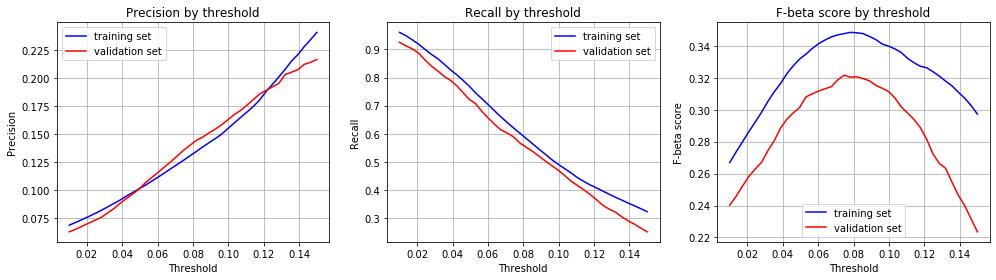

In [55]:
beta = 2
rcParams['figure.figsize'] = 14, 4
eval_ = EvaluateResults(y_train_all, y_val_all, y_pred_train_all, y_pred_val_all, model_name,\
            test_data)
eval_.find_threshold(beta=beta, threshold_min=0.01, threshold_max=0.15, resolution=40)

## Evaluate results

In [56]:
threshold = 0.075
beta = 2
print(model_name)
print('\n')
print('Predict crash in:            ' + str(month_prediction) + ' months')
print('Threshold for positives:     ' + str(threshold))
print('Number of features:          ' + str(dfs_x[0].shape[1]))
print('Number of rows for training: ' + str(len(y_pred_train_all[0]) + len(y_pred_val_all[0])))
print('\n')
eval_.training_results(threshold, training_set_names, beta=beta)

Linear Regression


Predict crash in:            3 months
Threshold for positives:     0.075
Number of features:          16
Number of rows for training: 45135


Results for each train/val split:
                       N225   SSE   HSI  BSESN   SMI  BVSP
positive actual train  0.06  0.04  0.06   0.06  0.05  0.06
positive pred train    0.29  0.17  0.30   0.28  0.28  0.29
precision train        0.15  0.12  0.12   0.13  0.13  0.12
recall train           0.75  0.46  0.64   0.63  0.64  0.60
accuracy_train         0.74  0.83  0.72   0.73  0.74  0.72
score_fbeta train      0.42  0.30  0.35   0.35  0.35  0.33
positive actual val    0.05  0.11  0.04   0.04  0.05  0.04
positive pred val      0.35  0.19  0.27   0.29  0.24  0.24
precision val          0.05  0.35  0.08   0.10  0.10  0.14
recall val             0.39  0.59  0.59   0.72  0.44  0.78
accuracy val           0.64  0.83  0.74   0.73  0.76  0.79
score fbeta val        0.17  0.52  0.27   0.31  0.26  0.41


Results - average over all train/va

## Test model

In [57]:
x_train, y_train, x_test, y_test = data.get_train_test(dfs_x, dfs_y, dataset_names, test_data)
y_train, y_test = y_train[:, index_month].astype(int), y_test[:, index_month].astype(int)
lm = linear_model.LinearRegression()
model = lm.fit(x_train, y_train)
y_pred_test = model.predict(x_test)
y_pred_test_bin = eval_.test_results(y_test, y_pred_test, threshold, beta=beta)

Test results (test set: S&P 500):
Positive test cases actual:         0.04
Positive test cases predicted:      0.27
Precision test (model/random):      0.11 / 0.04
Recall test (model/random):         0.76 / 0.27
Accuracy test (model/random):       0.75 / 0.71
Score test fbeta:                   0.35 / 0.13


## Plot test results

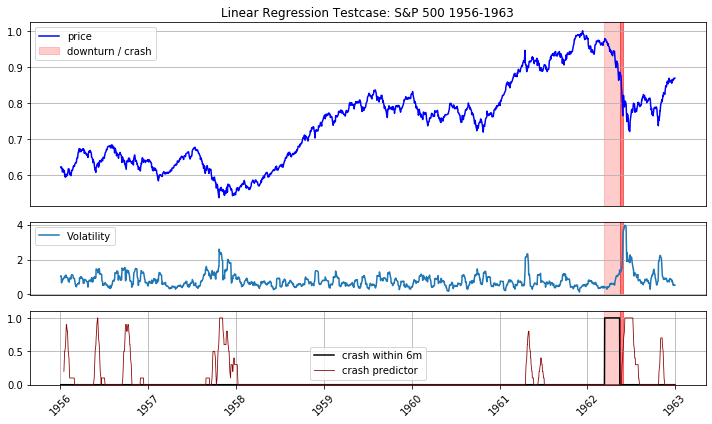

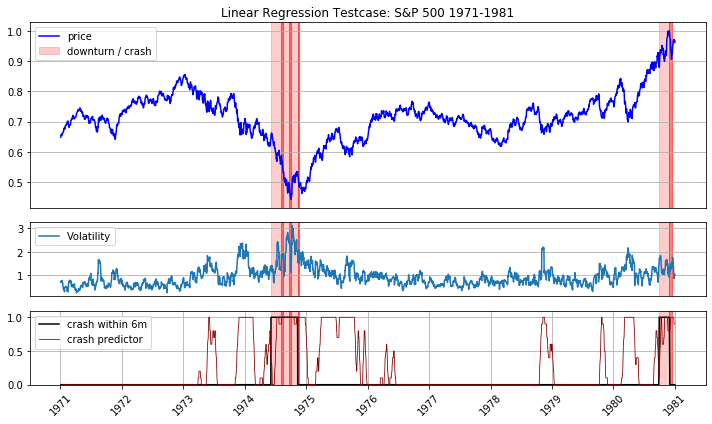

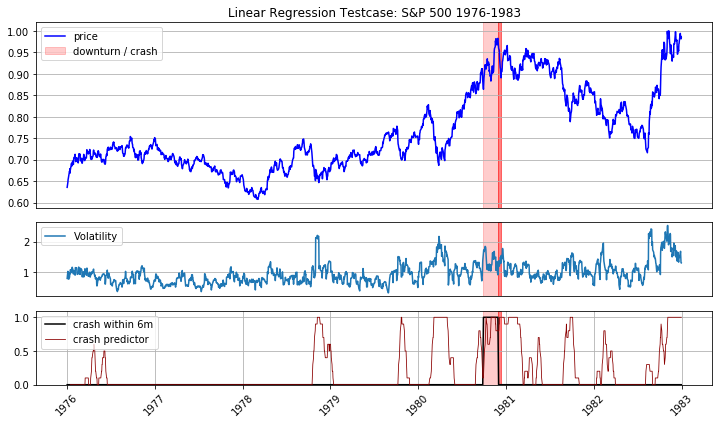

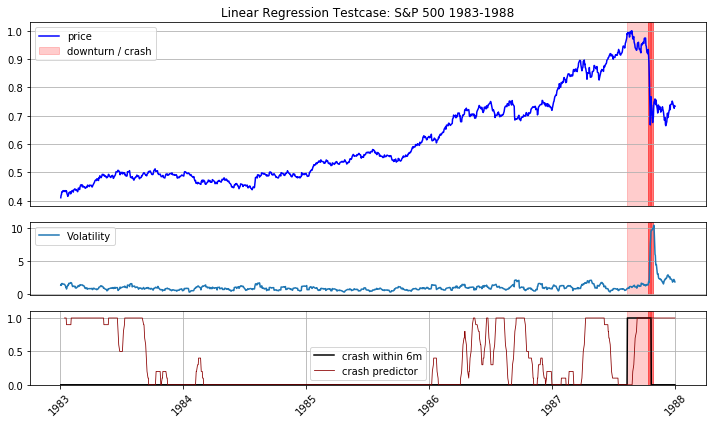

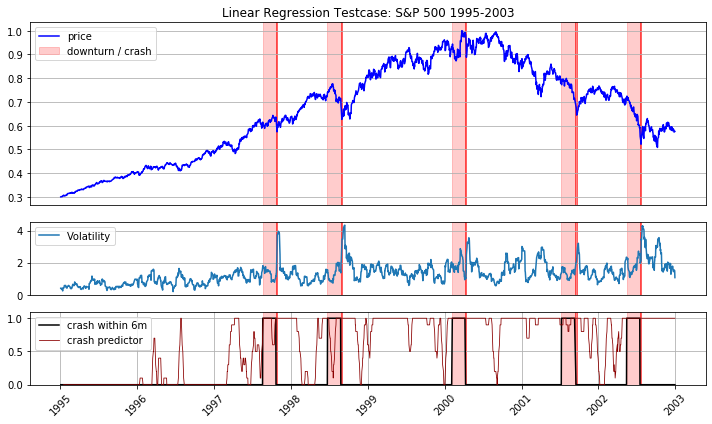

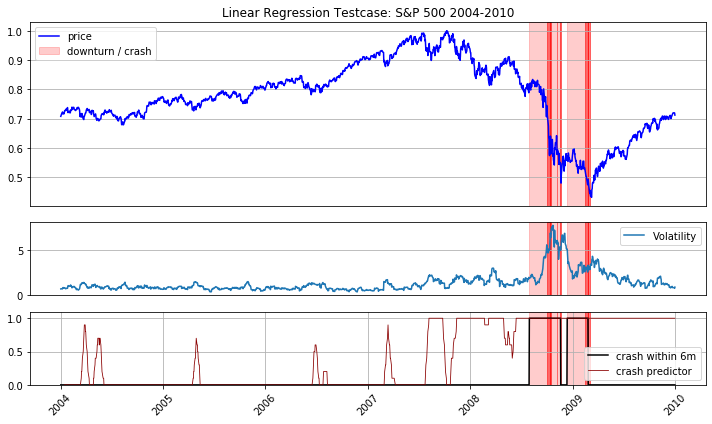

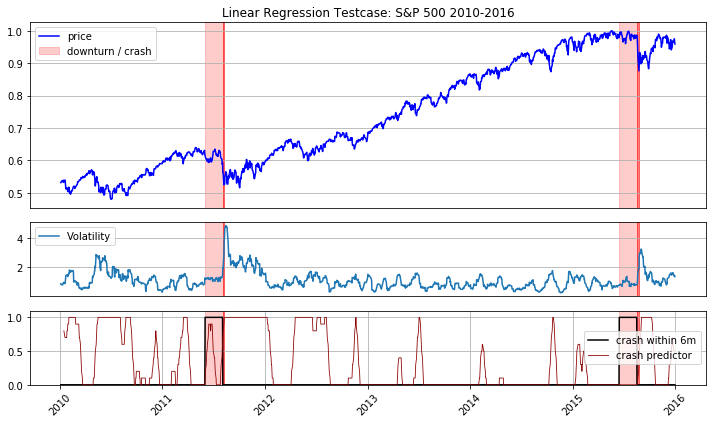

In [58]:
df = datasets_revised[index_test].reindex(dfs_x[index_test].index)
df['y'] = y_test
df['y_pred'] = y_pred_test_bin
c = crashes[index_test]
t_start = ['1956-01-01', '1971-01-01', '1976-01-01', '1983-01-01', '1995-01-01', '2004-01-01',\
            '2010-01-01']
t_end = ['1963-01-01', '1981-01-01', '1983-01-01', '1988-01-01', '2003-01-01', '2010-01-01', \
            '2016-01-01']
rcParams['figure.figsize'] = 10, 6
eval_.plot_test_results(df, c, t_start, t_end)

## Train on all available data:

In [59]:
x_train, y_train, _, _ = data.get_train_test(dfs_x, dfs_y, dataset_names, test_data=None)
thresholds = [0.07, 0.075, 0.085] # <-- determined by eval model for each prediction
dataset_original = ['^GSPC_11-05.csv']
dataset_name = ['S&P 500']
crash_threshold = [-0.0936]
data_new = DataLoader(dataset_original, dataset_name)
dataset_revised, crashes = data_new.get_data_revised(crash_threshold)
dfs_x_new, dfs_y_new = data_new.get_dfs_xy_predict(months=months)
x_new, _, _, _ = data_new.get_train_test(dfs_x_new, dfs_y_new, dataset_name, test_data=None)

for index_month in range(len(months)):
    y_train_ = y_train[:, index_month].astype(int)
    lm = linear_model.LinearRegression()
    model = lm.fit(x_train, y_train_)
    y_pred_new = model.predict(x_new)
    y_pred_new_bin = y_pred_new > thresholds[index_month]
    y_pred_new_bin = y_pred_new_bin.astype(int)
    current_pred = np.dot(np.linspace(0,1,42)/sum(np.linspace(0,1,42)), y_pred_new_bin[-42:])
    print(str(model_name) + ' prediction of a crash within ' + str(months[index_month]) \
          + ' months: ' + str(np.round(current_pred, 2)))

Linear Regression prediction of a crash within 1 months: 0.0
Linear Regression prediction of a crash within 3 months: 0.14
Linear Regression prediction of a crash within 6 months: 0.74
